**LOADING THE DATA**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import re

data_df = pd.read_csv('/content/telecom_churn_data.csv',sep=',',encoding="ISO-8859-1",header=0)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB



**Cleaning the data**

In [ ]:
null_counts = data_df.isnull().sum()

# Filter columns that have null values
columns_with_nulls = null_counts[null_counts > 0]

# Print the columns with their respective counts of null values
for column, count in columns_with_nulls.items():
    print(f"Column '{column}' has {count} null values. perectage '{(count/len(data_df))*100}'")

threshold = len(data_df)*0.5
data_df_1 = data_df.dropna(axis=1,thresh=threshold)

del data_df

for col in data_df_1:
    if data_df_1[col].dtype == 'object':  # Categorical data
        data_df_1[col].fillna(data_df_1[col].mode()[0], inplace=True)
    elif np.issubdtype(data_df_1[col].dtype, np.number):  # Numeric data
        data_df_1[col].fillna(data_df_1[col].mean(), inplace=True)

Column 'loc_og_t2o_mou' has 1018 null values. perectage '1.018010180101801'
Column 'std_og_t2o_mou' has 1018 null values. perectage '1.018010180101801'
Column 'loc_ic_t2o_mou' has 1018 null values. perectage '1.018010180101801'
Column 'last_date_of_month_7' has 601 null values. perectage '0.6010060100601006'
Column 'last_date_of_month_8' has 1100 null values. perectage '1.1000110001100012'
Column 'last_date_of_month_9' has 1659 null values. perectage '1.6590165901659015'
Column 'onnet_mou_6' has 3937 null values. perectage '3.9370393703937037'
Column 'onnet_mou_7' has 3859 null values. perectage '3.859038590385904'
Column 'onnet_mou_8' has 5378 null values. perectage '5.3780537805378055'
Column 'onnet_mou_9' has 7745 null values. perectage '7.745077450774509'
Column 'offnet_mou_6' has 3937 null values. perectage '3.9370393703937037'
Column 'offnet_mou_7' has 3859 null values. perectage '3.859038590385904'
Column 'offnet_mou_8' has 5378 null values. perectage '5.3780537805378055'
Column

<ipython-input-171-ca77a7470496>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df_1[col].fillna(data_df_1[col].mean(), inplace=True)
<ipython-input-171-ca77a7470496>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_1[col].fillna(data_df_1[col].mean(), inplace=True)
<ipython-input-171-ca77a7470496>:17: FutureWarning: A value i

**FILTERATION FOR HIGH VALUE CUSTOMERt**

In [ ]:
rech_indx = [indx for indx, col in enumerate(data_df_1.columns) if 'rech'  in col or 'rch' in col]
rech_indx.extend([0,9,10,11,12])
rech_indx.sort()
rch = data_df_1.iloc[:,rech_indx]
#Those who have recharged with an amount more than or equal to X,
#where X is the 70th percentile of the average recharge amount in the first two months (the good phase)t

percentile_70 = ((rch['arpu_6']+rch['arpu_7'])/2).quantile(0.7)
print(percentile_70)
rch['high_cust'] = percentile_70 <= rch[['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','max_rech_amt_9']].max(axis=1)

tem =rch
tem = tem[tem['high_cust']==True]
tem.shape

data_df_1=data_df_1[data_df_1['mobile_number'].isin(tem['mobile_number'])]
data_df_1.shape
del tem
del rch
data_df_1.describe()

317.30929999999984


<ipython-input-172-8d1179db304c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rch['high_cust'] = percentile_70 <= rch[['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','max_rech_amt_9']].max(axis=1)


Creating new columns

In [ ]:
data_df_1['arpu_avg']=data_df_1[['arpu_6','arpu_7','arpu_8','arpu_9']].mean(axis=1)
data_df_1['total_rech_num_avg']=data_df_1[['total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_num_9']].mean(axis=1)
data_df_1['max_rech_amt_avg']=data_df_1[['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','max_rech_amt_9']].max(axis=1)
data_df_1['total_rech_num_avg']=data_df_1[['total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_num_9']].mean(axis=1)
data_df_1['total_rech_num_avg'] =round(data_df_1['total_rech_num_avg'])



**Tag churner**

In [ ]:
data_df_1.loc[:,['mobile_number','total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']]

data_df_1['churn']=np.where((data_df_1['total_og_mou_9']<1)|(data_df_1['total_ic_mou_9']<1),
                           np.where((data_df_1['vol_2g_mb_9']<1)|(data_df_1['vol_3g_mb_9']<1),0,1),1)

In [ ]:
data_df_1.loc[:,['mobile_number','total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9','churn']]
data_df_1['churn'].value_counts()

,count
churn,
1,6529
0,785


<Axes: xlabel='churn', ylabel='count'>

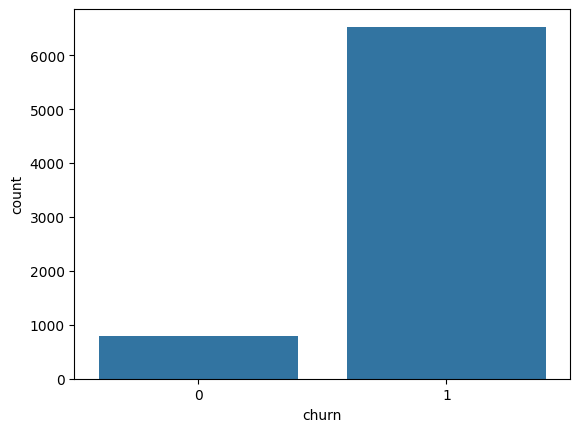

In [ ]:
sns.countplot(x='churn',data=data_df_1)

SELECTING THE COLUMNS FOR THE MODEL

In [ ]:
fil = [x for x in data_df_1.columns if not re.search(r'\d$', x)]
print(fil)
model_data = data_df_1.loc[:,fil]
model_data.info()


['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'arpu_avg', 'total_rech_num_avg', 'max_rech_amt_avg', 'churn']
<class 'pandas.core.frame.DataFrame'>
Index: 28484 entries, 0 to 99995
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mobile_number       28484 non-null  int64  
 1   circle_id           28484 non-null  int64  
 2   loc_og_t2o_mou      28484 non-null  float64
 3   std_og_t2o_mou      28484 non-null  float64
 4   loc_ic_t2o_mou      28484 non-null  float64
 5   aon                 28484 non-null  int64  
 6   aug_vbc_3g          28484 non-null  float64
 7   jul_vbc_3g          28484 non-null  float64
 8   jun_vbc_3g          28484 non-null  float64
 9   sep_vbc_3g          28484 non-null  float64
 10  arpu_avg            28484 non-null  float64
 11  total_rech_num_avg  28484 non-null  float64

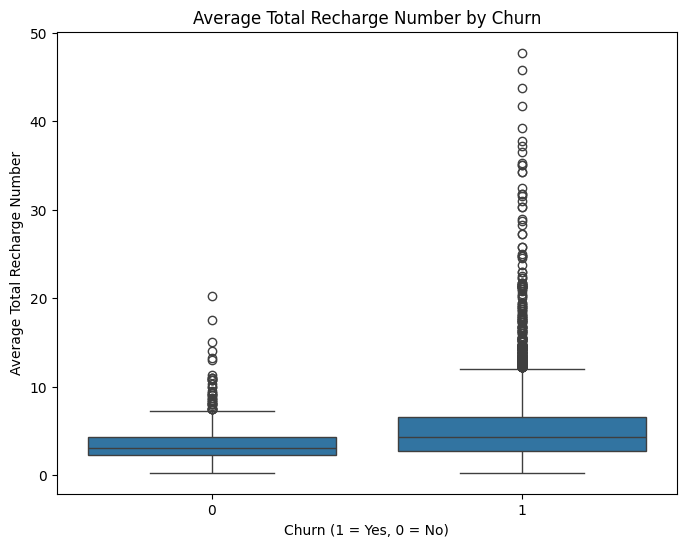

In [ ]:
# @title Average Total Recharge Number by Churn

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='churn', y='total_rech_num_avg', data=model_data)
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Average Total Recharge Number')
_ = plt.title('Average Total Recharge Number by Churn')

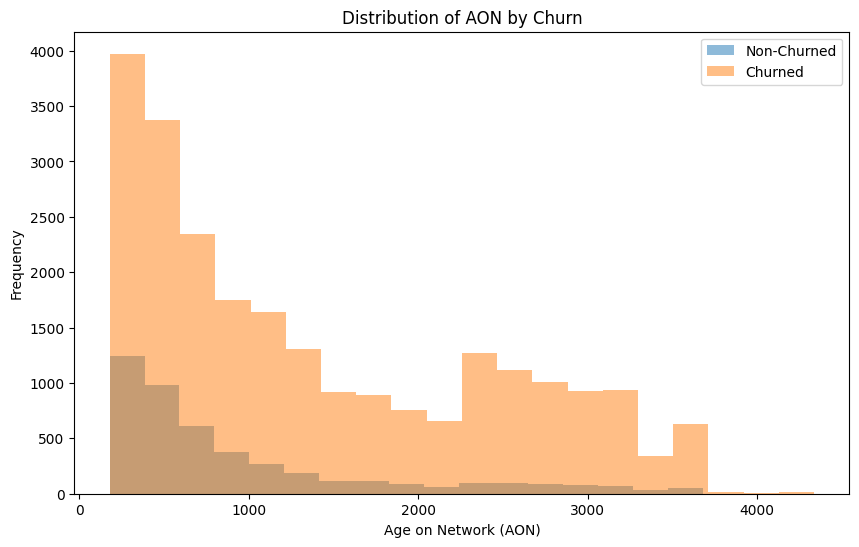

In [ ]:
# @title Distribution of AON by Churn

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(model_data[model_data['churn'] == 0]['aon'], bins=20, alpha=0.5, label='Non-Churned')
plt.hist(model_data[model_data['churn'] == 1]['aon'], bins=20, alpha=0.5, label='Churned')
plt.xlabel('Age on Network (AON)')
plt.ylabel('Frequency')
plt.title('Distribution of AON by Churn')
_ = plt.legend()

MODEL BUILDING


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
#SPILITING THE DATA INTO TRAIN AND TEST
x_model = model_data.iloc[:,5:13]
print(x_model.columns)
y_model= model_data['churn']
x_train,x_test,y_train,y_test = train_test_split(x_model,y_model,train_size=0.7,test_size=0.3,random_state=42)

CHURN_RATE


In [ ]:
churn_rate= (sum(y_train)/len(y_train))*100
print(churn_rate)

83.85996589427225


FEATURE SCALING

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_scaler=pd.DataFrame(x_train_scaled,columns=x_model.columns)
x_scaler

,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,arpu_avg,total_rech_num_avg,max_rech_amt_avg
0,-0.252688,-0.270490,-0.243114,-0.226920,-0.101232,-0.471062,-0.797555,-0.233595
1,0.821996,-0.270490,-0.243114,-0.226920,-0.101232,-0.424549,-0.797555,0.119908
2,1.944092,-0.270490,-0.243114,-0.226920,-0.101232,0.167807,2.108373,-0.752938
3,-0.390975,-0.270490,-0.243114,-0.226920,-0.101232,-0.156812,0.862975,-0.447442
4,-0.666560,-0.270490,-0.243114,-0.226920,-0.101232,-0.657120,-0.797555,-0.534726
...,...,...,...,...,...,...,...,...
19933,-0.627050,0.649038,0.884060,0.044071,0.442283,0.420250,-0.382423,0.338119
19934,-0.878929,0.892017,7.850441,5.924756,-0.101232,-0.229235,-1.212688,0.128636
19935,0.876322,-0.270490,-0.243114,-0.226920,-0.101232,-0.728810,-0.797555,-0.403799
19936,-0.628038,-0.270490,-0.243114,-0.226920,-0.101232,-0.720719,-0.382423,-0.403799


LOOKING FOR COORELATION

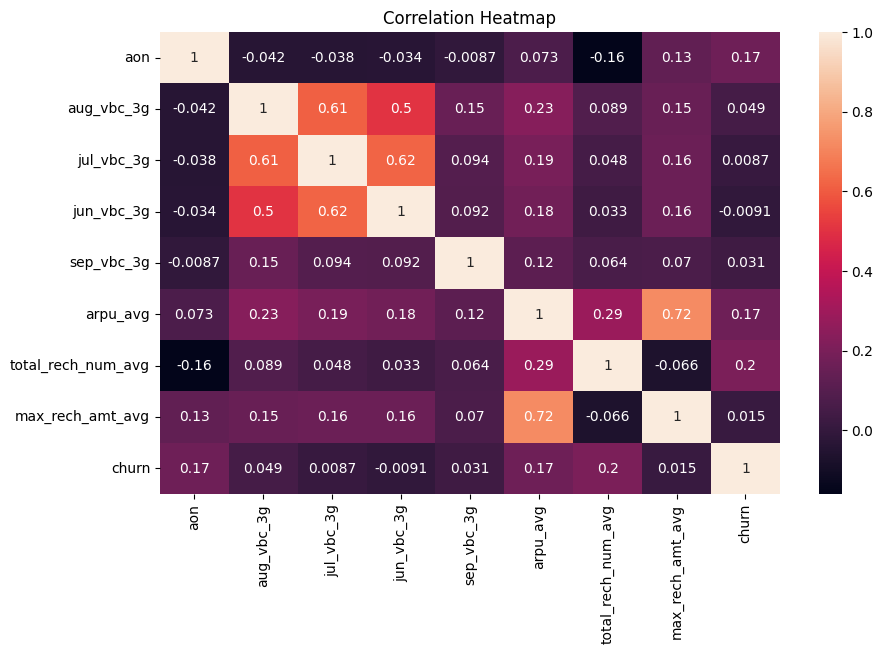

In [ ]:
t=model_data.iloc[:,5:]

plt.figure(figsize=(10, 6))
sns.heatmap(t.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()



In [ ]:
 ytrain=y_train.values
 ytrain = pd.DataFrame(ytrain,columns=['churn'])
 ytrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19938 entries, 0 to 19937
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   churn   19938 non-null  int64
dtypes: int64(1)
memory usage: 155.9 KB


RUNNING THE TRAIN MODEL


In [ ]:
import statsmodels.api as sm

logical = sm.GLM(ytrain, sm.add_constant(x_scaler), family=sm.families.Binomial())
logical.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19938
Model:                            GLM   Df Residuals:                    19929
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7330.7
Date:                Tue, 17 Dec 2024   Deviance:                       14661.
Time:                        11:43:18   Pearson chi2:                 2.26e+08
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1381
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2351      0.031     72.946      0.000       2.175       2.295
aon                    0.6779      0.026     26.245      0.000       0.627       0.729
aug_vbc_3g             0.1584      0.039      4.078      0.000       0.082       0.235
jul_vbc_3g            -0.0494      0.033     -1.516      0.129      -0.113       0.014
jun_vbc_3g            -0.1295      0.029     -4.459      0.000      -0.186      -0.073
sep_vbc_3g             0.0953      0.057      1.668      0.095      -0.017       0.207
arpu_avg               1.4028      0.062     22.468      0.000       1.280       1.525
total_rech_num_avg     0.7642      0.038     19.891      0.000       0.689       0.840
max_rech_amt_avg      -0.7010      0.038    -18.645      0.000      -0.775      -0.627
======================================================================================
"""

FEATURE SELECTION USING RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logre = LogisticRegression()
rfe = RFE(logre,n_features_to_select=8)
rfe.fit(x_scaler,ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RFE(estimator=LogisticRegression(), n_features_to_select=8)

In [ ]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
list(zip(x_scaler.columns,rfe.support_,rfe.ranking_))

[('aon', True, 1),
 ('aug_vbc_3g', True, 1),
 ('jul_vbc_3g', True, 1),
 ('jun_vbc_3g', True, 1),
 ('sep_vbc_3g', True, 1),
 ('arpu_avg', True, 1),
 ('total_rech_num_avg', True, 1),
 ('max_rech_amt_avg', True, 1)]

ASSESSING THE MODEL WITH STATEMODEL

In [ ]:
from math import log
xtrain_sm = sm.add_constant(x_scaler)
logm2 = sm.GLM(ytrain,xtrain_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                19938
Model:                            GLM   Df Residuals:                    19929
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7330.7
Date:                Tue, 17 Dec 2024   Deviance:                       14661.
Time:                        11:43:32   Pearson chi2:                 2.26e+08
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1381
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2351      0.031     72.946      0.000       2.175       2.295
aon                    0.6779      0.026     26.245      0.000       0.627       0.729
aug_vbc_3g             0.1584      0.039      4.078      0.000       0.082       0.235
jul_vbc_3g            -0.0494      0.033     -1.516      0.129      -0.113       0.014
jun_vbc_3g            -0.1295      0.029     -4.459      0.000      -0.186      -0.073
sep_vbc_3g             0.0953      0.057      1.668      0.095      -0.017       0.207
arpu_avg               1.4028      0.062     22.468      0.000       1.280       1.525
total_rech_num_avg     0.7642      0.038     19.891      0.000       0.689       0.840
max_rech_amt_avg      -0.7010      0.038    -18.645      0.000      -0.775      -0.627
======================================================================================
"""

In [ ]:
y_train_pred = res.predict(xtrain_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.72033328, 0.81638986, 0.99731216, 0.93773864, 0.64922552,
       0.98697396, 0.78053679, 0.65413183, 0.98527144, 0.88611329])

creating df with churn flag and churn probability


In [ ]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,id,predicted
0,1,0.720333,19396,1
1,1,0.816390,95007,1
2,1,0.997312,21148,1
3,1,0.937739,21954,1
4,1,0.649226,56934,1


In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confused = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted)
print(confused)
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

[[  414  2804]
 [  151 16569]]
0.8517905507071923


checking vip

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = x_scaler.columns
vif['VIF'] = [variance_inflation_factor(x_scaler.values, i) for i in range(x_scaler.shape[1])]
vif

,Features,VIF
0,aon,1.050426
1,aug_vbc_3g,1.753085
2,jul_vbc_3g,2.125295
3,jun_vbc_3g,1.771770
4,sep_vbc_3g,1.035445
5,arpu_avg,2.852624
6,total_rech_num_avg,1.342057
7,max_rech_amt_avg,2.570753


In [ ]:
tp = confused[0,0]
tn = confused[1,1]
fp = confused[0,1]
fn = confused[1,0]
print(tp,tn,fp,fn)

414 16569 2804 151


In [ ]:
print(f'sensitivity = {tp/float(tp+fn)}')
print(f'specificity = {tn/float(tn+fp)}')
print(f'false positive rate = {fp/float(tn+fp)}')
print(f'false negative rate = {fn/float(tp+fn)}')
print(f'positive predictive value = {tp/float(tp+fp)}')
print(f'negative predictive value = {tn/float(tn+fn)}')



sensitivity = 0.7327433628318584
specificity = 0.8552624787074795
false positive rate = 0.14473752129252052
false negative rate = 0.2672566371681416
positive predictive value = 0.12865133623368552
negative predictive value = 0.9909688995215311


drawing ROC CURVE

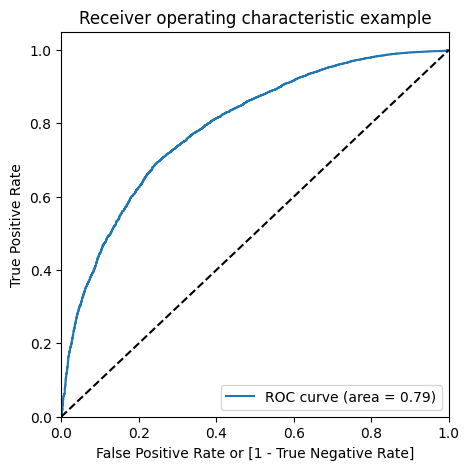

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

# Calling the function
draw_roc(y_train_pred_final.Churn,y_train_pred_final.Churn_Prob )

OPTIMINAL THESHOLD

In [ ]:
n =[float(x)/10 for x in range(10)]
for i in n:
  y_train_pred_final[i] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
print(y_train_pred_final.head())



cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn,y_train_pred_final[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1

    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

   Churn  Churn_Prob     id  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0      1    0.720333  19396          1    1    1    1    1    1    1    1   
1      1    0.816390  95007          1    1    1    1    1    1    1    1   
2      1    0.997312  21148          1    1    1    1    1    1    1    1   
3      1    0.937739  21954          1    1    1    1    1    1    1    1   
4      1    0.649226  56934          1    1    1    1    1    1    1    1   

   0.7  0.8  0.9  
0    1    0    0  
1    1    1    0  
2    1    1    1  
3    1    1    1  
4    0    0    0  
     prob  accuracy     sensi     speci
0.0   0.0  0.838600  1.000000  0.000000
0.1   0.1  0.838449  0.999402  0.002175
0.2   0.2  0.838449  0.998923  0.004661
0.3   0.3  0.838700  0.998026  0.010876
0.4   0.4  0.843565  0.996531  0.048788
0.5   0.5  0.851791  0.990969  0.128651
0.6   0.6  0.851891  0.963397  0.272530
0.7   0.7  0.819892  0.890490  0.453076
0.8   0.8  0.740997  0.752632  0.680547
0.9   0.9  0.557528  0.

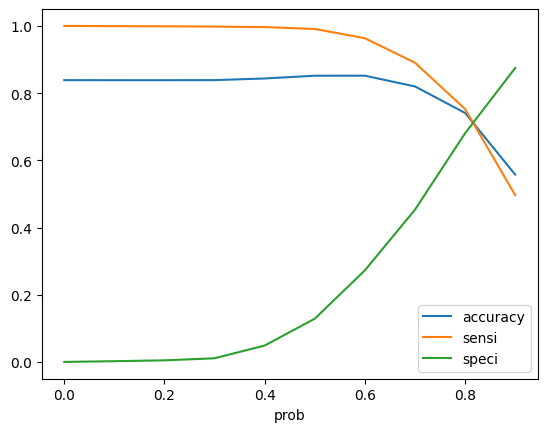

In [ ]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [ ]:
#precision
print(f'precision={tp/(tp+fp)}')
#recall
print(f'Recall={tp/(tp+fn)}')

precision=0.12865133623368552
Recall=0.7327433628318584


In [ ]:
from sklearn.metrics import precision_recall_curve,precision_score,recall_score

precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.8552624787074795

In [ ]:
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.9909688995215311

In [ ]:
p,r,threshold = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

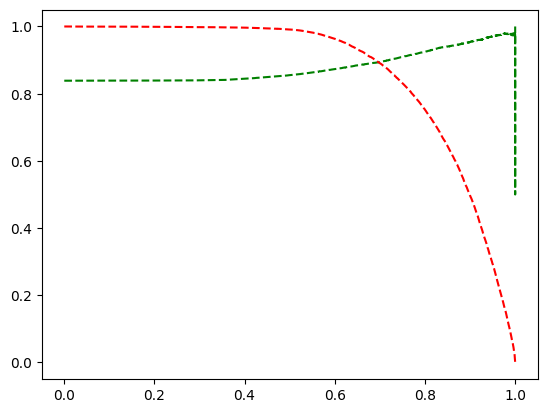

In [ ]:
plt.plot(threshold,p[:-1],'g--',label='precision')
plt.plot(threshold,r[:-1],'r--',label='recall')
plt.show()

In [ ]:
cutoff_df

,prob,accuracy,sensi,speci
0.0,0.0,0.838600,1.000000,0.000000
0.1,0.1,0.838449,0.999402,0.002175
0.2,0.2,0.838449,0.998923,0.004661
0.3,0.3,0.838700,0.998026,0.010876
0.4,0.4,0.843565,0.996531,0.048788
0.5,0.5,0.851791,0.990969,0.128651
0.6,0.6,0.851891,0.963397,0.272530
0.7,0.7,0.819892,0.890490,0.453076
0.8,0.8,0.740997,0.752632,0.680547
0.9,0.9,0.557528,0.496471,0.874767


In [ ]:
x_test_scaled = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled,columns=x_model.columns)
xtest_sm = sm.add_constant(x_test_scaled)


In [ ]:
y_test_pred = res.predict(xtest_sm)
y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred[:10]

array([0.7821856 , 0.89956188, 0.73231945, 0.95869785, 0.80795543,
       0.77949946, 0.92001792, 0.99891659, 0.83968797, 0.96085643])

In [ ]:
y_pred_1= pd.DataFrame(y_test_pred)
y_test_df = pd.DataFrame(y_test)
y_test_df['id'] = y_test.index
y_test_df.reset_index(drop=True,inplace=True)
y_pred_1.reset_index(drop=True,inplace=True)
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns={0:'Churn_Prob'})
y_pred_final = y_pred_final.loc[:,['id','churn','Churn_Prob']]
y_pred_final.head()

,id,churn,Churn_Prob
0,60401,1,0.782186
1,95400,1,0.899562
2,31810,0,0.732319
3,67707,1,0.958698
4,9183,1,0.807955


In [ ]:
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.78 else 0)
y_pred_final.head()

,id,churn,Churn_Prob,predicted
0,60401,1,0.782186,1
1,95400,1,0.899562,1
2,31810,0,0.732319,0
3,67707,1,0.958698,1
4,9183,1,0.807955,1


In [ ]:
print(metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted))
confused2=confusion_matrix(y_pred_final.churn, y_pred_final.predicted)
print(confused2)

0.7562602387081676
[[ 878  491]
 [1592 5585]]


In [ ]:
tp1 = confused2[0,0]
tn1 = confused2[1,1]
fp1 = confused2[0,1]
fn1 = confused2[1,0]
print(tp1,tn1,fp1,fn1)

print(f'sensitivity = {tp1/float(tp1+fn1)}')
print(f'specificity = {tn1/float(tn1+fp1)}')

878 5585 491 1592
sensitivity = 0.3554655870445344
specificity = 0.9191902567478605


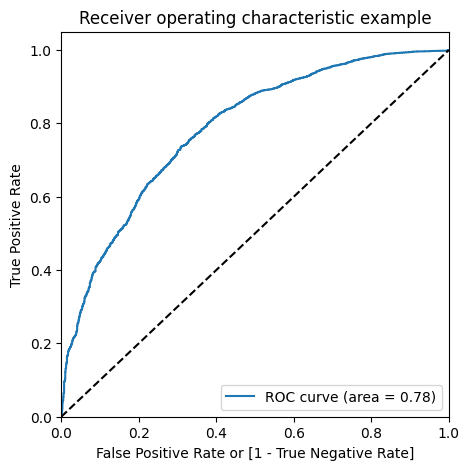

In [ ]:
draw_roc(y_pred_final.churn,y_pred_final.Churn_Prob )